In [159]:
import sys
sys.stdout = open('data/ganrec/print/write.txt', 'w')
import lib

In [160]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Dense, Conv2D, Conv2DTranspose, \
    Flatten, concatenate, \
        BatchNormalization, Dropout, \
            ReLU,LeakyReLU, Add, Activation
from tensorflow.keras.models import Model, Sequential, load_model

def dense_norm(units, dropout, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Dense(units, 
            #   activation=tf.nn.tanh, 
              use_bias=True, 
              kernel_initializer=initializer))
    result.add(Dropout(dropout))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def conv2d_norm(filters, size, strides, apply_batchnorm=True):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2D(filters, 
               size, 
               strides=strides, 
               padding='same',
               kernel_initializer=initializer, 
               use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result


def dconv2d_norm(filters, size, strides, apply_dropout=False):
    initializer = tf.random_normal_initializer()

    result = Sequential()
    result.add(
        Conv2DTranspose(filters, 
                        size, 
                        strides=strides,
                        padding='same',
                        kernel_initializer=initializer,
                        use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.25))

    result.add(LeakyReLU())

    return result



def make_generator(img_h, img_w, conv_num, conv_size, dropout, output_num):
    units = 128
    fc_size = img_h * img_w
    inputs = Input(shape=(img_h, img_w, 1))
    x = Flatten()(inputs)
    fc_stack = [
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size, 1),

    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]

    last = conv2d_norm(output_num, 3, 1)

    for fc in fc_stack:
        x = fc(x)

    x = tf.reshape(x, shape=[-1, img_h, img_w, 1])
    # Convolutions
    for conv in conv_stack:
        x = conv(x)

    for dconv in dconv_stack:
        x = dconv(x)
    x = last(x)
    
    model = Model(inputs=inputs, outputs=x)
    print("finally the model is: \n", model.summary()) 
    return model


def make_generator2(img_h, img_w, conv_num, conv_size, dropout, output_num):
    print("function: make_generator\******************************\ninputs are: \nimg_h {}, img_w {}, conv_num {}, conv_size {}, dropout {}, output_num {}".format(
        img_h, img_w, conv_num, conv_size, dropout, output_num))
    
    units = 128
    fc_size = img_w ** 2
    inputs = Input(shape=(img_h, img_w, 1))
    fc_stack = [
        dense_norm(units, dropout),
        # dense_norm(units, dropout),
        # dense_norm(units, dropout),
        dense_norm(fc_size, 0),
    ]

    conv_stack = [
        conv2d_norm(conv_num, conv_size+2, 1),
        conv2d_norm(conv_num, conv_size+2, 1),
        # conv2d_norm(conv_num, conv_size, 1),
        conv2d_norm(conv_num, conv_size, 1),

    ]

    dconv_stack = [
        dconv2d_norm(conv_num, conv_size+2, 1),
        dconv2d_norm(conv_num, conv_size+2, 1),
        # dconv2d_norm(conv_num, conv_size, 1),
        dconv2d_norm(conv_num, conv_size, 1),
    ]
    
    last_1 = conv2d_norm(1, 3, 1)
    last = conv2d_norm(output_num, 3, 1)

    x = conv2d_norm(conv_num, conv_size+2, 1)(inputs)
    x = conv2d_norm(conv_num, conv_size+2, 1)(x)
    x = dconv2d_norm(conv_num, conv_size+2, 1)(x)
    x = dconv2d_norm(conv_num, conv_size, 1)(x)
    x = last_1(x)
    x = Flatten()(x)
    x = dense_norm(units, dropout)(x)
    x = dense_norm(units, dropout)(x)
    x = dense_norm(fc_size, 0)(x)
    x = tf.reshape(x, shape=[-1, img_w, img_w, 1])
    # Convolutions
    x = conv2d_norm(conv_num, conv_size+2, 1)(x)
    x = conv2d_norm(conv_num, conv_size, 1)(x)
    x = dconv2d_norm(conv_num, conv_size+2, 1)(x)
    x = dconv2d_norm(conv_num, conv_size, 1)(x)
    x = last(x)
    
    model = Model(inputs=inputs, outputs=x)
    print("finally the model is: \n", model.summary()) 
    return model


def make_filter(img_h, img_w):
    inputs = Input(shape=[img_h, img_w, 1])
    down_stack = [
        conv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 64)
        conv2d_norm(16, 3, 1)
    ]

    up_stack = [

        dconv2d_norm(16, 3, 1),  # (batch_size, 128, 128, 128)
        dconv2d_norm(16, 3, 1)
    ]
    last = conv2d_norm(1, 3, 1)
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)


def make_discriminator(nang, px):
    model = Sequential()
    model.add(Conv2D(16, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[nang, px, 1]))
    model.add(Conv2D(16, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    # model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1))

    print("finally the model is: \n", model.summary())

    return model


In [196]:
import numpy as np
from numpy.fft import fftfreq
import matplotlib.pyplot as plt

def nor_phase(img):
    mean_tmp = np.mean(img)
    std_tmp = np.std(img)
    img = (img - mean_tmp) / std_tmp
    return img


def ffactor(px, py, energy, z, pv):
    lambda_p = 1.23984122e-09 / energy
    frequ_prefactor = 2 * np.pi * lambda_p * z / pv ** 2
    freq_x = fftfreq(px)
    freq_y = fftfreq(py)
    xi, eta = np.meshgrid(freq_x, freq_y)
    xi = xi.astype('float32')
    eta = eta.astype('float32')
    h = np.exp(- 1j * frequ_prefactor * (xi ** 2 + eta ** 2) / 2)
    h = h.T
    return h.astype('complex64')

def fresnel_operator(px, py, pv, z, energy):
    from numpy.fft import fftfreq
    from numpy import pi 
    lambda0 = 1.23984122e-09 / energy
    upsample_scale = 1;                 # Scale by which to upsample image
    nx = upsample_scale * px # Image width in pixels (same as height)
    ny = upsample_scale * py # Image height in pixels
    grid_size_x = pv * nx;                 # Grid size in x-direction
    grid_size_y = pv * ny;                 # Grid size in y-direction
    # Inverse space
    fx = np.linspace(-(nx-1)/2*(1/grid_size_x), (nx-1)/2*(1/grid_size_x), nx)
    fy = np.linspace(-(ny-1)/2*(1/grid_size_y), (ny-1)/2*(1/grid_size_y), ny)
    Fx, Fy = np.meshgrid(fx, fy)
    H = np.exp(1j*(2 * pi / lambda0) * z) * np.exp(1j * pi * lambda0 * z * (Fx**2 + Fy**2))
    return H.T

class RECONmonitor:
    def __init__(self, recon_target):
        self.fig, self.axs = plt.subplots(2, 3, figsize=(23, 8))
        self.recon_target = recon_target
        if self.recon_target == 'tomo':
            self.plot_txt = 'Sinogram'
        elif self.recon_target == 'phase':
            self.plot_txt = 'Intensity'
      

    def initial_plot(self, img_input):
        px, py = img_input.shape
        self.im0 = self.axs[0, 0].imshow(img_input, cmap='gray')
        self.axs[0, 0].set_title(self.plot_txt)
        self.fig.colorbar(self.im0, ax=self.axs[0, 0])
        self.axs[0, 0].set_aspect('equal','box')
        self.im1 = self.axs[1, 0].imshow(img_input, cmap='jet')
        self.tx1 = self.axs[1, 0].set_title('Difference of ' + self.plot_txt + ' for iteration 0')
        self.fig.colorbar(self.im1, ax=self.axs[1, 0])
        self.axs[0, 0].set_aspect('equal')
        self.im2 = self.axs[0, 1].imshow(np.zeros((px, py)), cmap='gray')
        self.fig.colorbar(self.im2, ax=self.axs[0, 1])
        self.axs[0, 1].set_title('Reconstruction')
        self.im3, = self.axs[1, 1].plot([], [], 'r-')
        self.axs[1, 1].set_title('Generator loss')
        self.axs[0, 2].set_title('plot profile of input')
        self.axs[0, 2].plot(img_input[int(px/2), :], 'b-')
        self.axs[0, 2].set_title('plot profile of input')
        self.im4 = self.axs[1, 2].plot([], 'r-')
        self.axs[1, 2].set_title('plot profile of recon')
        


        plt.tight_layout()

    def update_plot(self, epoch, img_diff, img_rec, plot_x, plot_loss):
        self.tx1.set_text('Difference of ' + self.plot_txt + ' for iteration {0}'.format(epoch))
        vmax = np.max(img_diff)
        vmin = np.min(img_diff)
        self.im1.set_data(img_diff)
        self.im1.set_clim(vmin, vmax)
        self.im2.set_data(img_rec)
        vmax = np.max(img_rec)
        vmin = np.min(img_rec)
        self.im2.set_clim(vmin, vmax)
        self.axs[1, 1].plot(plot_x, plot_loss, 'r-')
        #axs 1,2 is the plot profile of recon
        self.axs[1, 2].plot(img_rec[int(img_rec.shape[0]/2), :], 'r-')
        # plt.tight_layout()
        plt.pause(0.1)
        #save the plot with the epoch number
        if epoch%100==0:
            #5 significant digits
            plt.savefig('data/ganrec/recon/recon_{0:05d}.png'.format(epoch))
    def close_plot(self):
        plt.close()


In [197]:
import tensorflow as tf

import os
import numpy as np

# @tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_output,
                                                                       labels=tf.ones_like(real_output)))
    fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                       labels=tf.zeros_like(fake_output)))
    total_loss = real_loss + fake_loss
    return total_loss


def l1_loss(img1, img2):
    return tf.reduce_mean(tf.abs(img1 - img2))
def l2_loss(img1, img2):
    return tf.square(tf.reduce_mean(tf.abs(img1-img2)))



# @tf.function
def generator_loss(fake_output, img_output, pred, l1_ratio):
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                      labels=tf.ones_like(fake_output))) \
               + l1_loss(img_output, pred) * l1_ratio
    return gen_loss


# @tf.function
def filer_loss(fake_output, img_output, img_filter):
    f_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_output,
                                                                    labels=tf.ones_like(fake_output))) + \
              l1_loss(img_output, img_filter) *10
              # l1_loss(img_output, img_filter) * 10
    return f_loss



def tfnor_phase(img):
    img = tf.image.per_image_standardization(img)
    img = img / tf.reduce_max(img)
    return img

def FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None):
    """  Parameters: 
            E0 - initial complex field in x-y source plane
            pv - pixel size in microns
            lambda0 - wavelength in nm
            z - z-value (distance from sensor to object)
            background - optional background image to divide out from
        
        Returns: E1 - propagated complex field in x-y sensor plane"""  
    import os
    dtype = tf.complex64
    H = tf.cast(ff, dtype)
    detector_wavefield = tf.exp(tf.complex(-absorption, phase))
    detector_wavefield = tf.cast(detector_wavefield, dtype)
    # Compute FFT centered about 0
    E0fft = (tf.signal.fft2d(detector_wavefield))
    E0fft = tf.cast(E0fft, dtype)

    # Multiply spectrum with fresnel phase-factor
    print("E0fft shape: ", E0fft.shape, "H shape: ", H.shape)
    G = H * E0fft
    # Ef = tf.signal.ifft2d(tf.signal.ifftshift(G)) # Output after deshifting Fourier transform
    I = tf.abs(tf.signal.ifft2d(G))**2
    I = tf.cast(I, tf.float32)
    if dark_image is not None and ref_image is not None:
        I = I * (ref_image - dark_image) + dark_image
    I = tfnor_phase(tf.reshape(I, [1, I.shape[0], I.shape[1], 1]))
    return I

def phase_fresnel(phase, absorption, ff, px, py):
    paddings = tf.constant([[px // 2, py // 2], [px // 2, py // 2]])
    # padding1 = tf.constant([[px // 2, px // 2], [0, 0]])
    # padding2 = tf.constant([[0, 0], [px // 2, px // 2]])
    pvalue = tf.reduce_mean(phase[:100, :])
    # phase = tf.pad(phase, paddings, 'CONSTANT',constant_values=1)
    phase = tf.pad(phase, paddings, 'SYMMETRIC')
    # phase = tf.pad(phase, paddings, 'REFLECT')
    absorption = tf.pad(absorption, paddings, 'SYMMETRIC')
    # phase = phase
    # absorption = absorption
    abfs = tf.complex(-absorption, phase)
    abfs = tf.exp(abfs)
    ifp = tf.abs(tf.signal.ifft2d(ff * tf.signal.fft2d(abfs))) ** 2
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.central_crop(ifp, 0.5)
    # ifp = tf.image.per_image_standardization(ifp)
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tfnor_phase(ifp)
    return ifp

def phase_fraunhofer(phase, absorption):
    wf = tf.complex(absorption, phase)
    # wf = tf.complex(phase, absorption)

    # wf = mask_img(wf)
    # wf = tf.multiply(ampl, tf.exp(phshift))
    # wf = tf.manip.roll(wf, [160, 160], [0, 1])
    ifp = tf.square(tf.abs(tf.signal.fft2d(wf)))  
    # # adding log to the fft
    # ifp = tf.math.log(ifp+8000)
    ifp = tf.math.log(ifp+10000)
    # ifp = tf.math.log(tf.abs(tf.signal.fft2d(wf))+1)
    # ifp = tf.math.log(tf.square(tf.abs(tf.signal.fft2d(wf)))+1)
    ifp = tf.signal.fftshift(ifp)
  
    # ifp = tf.roll(ifp, [256, 256], [0, 1])
    ifp = tf.reshape(ifp, [1, ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tfnor_diff(ifp)
    return ifp

class GANphase:
    def __init__(self, i_input, energy, z, pv, **kwargs):
        phase_args = _get_GANphase_kwargs()
        phase_args.update(**kwargs)
        super(GANphase, self).__init__()
        self.i_input = i_input
        self.shape = i_input.shape
        self.px, self.py = i_input.shape
        self.energy = energy
        self.z = z
        self.pv = pv
        self.iter_num = phase_args['iter_num']
        self.conv_num = phase_args['conv_num']
        self.conv_size = phase_args['conv_size']
        self.dropout = phase_args['dropout']
        self.l1_ratio = phase_args['l1_ratio']
        self.abs_ratio = phase_args['abs_ratio']
        self.g_learning_rate = phase_args['g_learning_rate']
        self.d_learning_rate = phase_args['d_learning_rate']
        self.phase_only = phase_args['phase_only']
        self.save_wpath = phase_args['save_wpath']
        self.init_wpath = phase_args['init_wpath']
        self.init_model = phase_args['init_model']
        self.recon_monitor = phase_args['recon_monitor']
        self.filter = None
        self.generator = None
        self.discriminator = None
        self.filter_optimizer = None
        self.generator_optimizer = None
        self.discriminator_optimizer = None
        # print('self properties:', self.__dict__.keys(), '\t', self.__dict__.values())

    def make_model(self):
        self.filter = make_filter(self.i_input.shape[0],
                                  self.i_input.shape[1])
        self.generator = make_generator(self.i_input.shape[0],
                                        self.i_input.shape[1],
                                        self.conv_num,
                                        self.conv_size,
                                        self.dropout,
                                        2)
        self.discriminator = make_discriminator(self.i_input.shape[0],
                                                self.i_input.shape[1])
        self.filter_optimizer = tf.keras.optimizers.Adam(5e-3)
        self.generator_optimizer = tf.keras.optimizers.Adam(self.g_learning_rate)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(self.d_learning_rate)

    def make_chechpoints(self):
        checkpoint_dir = '/data/ganrec/training_checkpoints'
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    @tf.function
    def rec_step(self, i_input, ff):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            recon = self.generator(i_input)
            # recon = tfa.image.median_filter2d(recon)
            phase = tfnor_phase(recon[:, :, :, 0])
            phase = tf.reshape(phase, [self.px, self.py])
            absorption = (tfnor_phase(recon[:, :, :, 1]))* self.abs_ratio
            absorption = tf.reshape(absorption, [self.px, self.py])
            if self.phase_only:
                absorption = tf.zeros_like(phase)
            # i_rec = phase_fresnel(phase, absorption, ff, self.px)
            i_rec = tfnor_phase(tf.reshape(FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None), [1, self.px, self.py, 1]))
            # i_rec = tf.reshape(FresnelPropagator(phase, absorption, ff, ref_image = None, dark_image = None), [1, self.px, self.py, 1])
            
            real_output = self.discriminator(i_input, training=True)
            fake_output = self.discriminator(i_rec, training=True)
            g_loss = generator_loss(fake_output, i_input, i_rec, self.l1_ratio)
            d_loss = discriminator_loss(real_output, fake_output)
        gradients_of_generator = gen_tape.gradient(g_loss,
                                                   self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(d_loss,
                                                        self.discriminator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                                     self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                         self.discriminator.trainable_variables))
        return {'phase': phase,
                'absorption': absorption,
                'i_rec': i_rec,
                'g_loss': g_loss,
                'd_loss': d_loss}


    @property
    def recon(self):
        # ff = ffactor(self.px * 2, self.py * 2, self.energy, self.z, self.pv)
        # print(ff.shape, ff.max(), ff.min())
        ff = fresnel_operator(self.px, self.py, self.pv, self.z, self.energy)
        i_input = np.reshape(self.i_input, (1, self.px, self.py, 1))
        i_input = tf.cast(i_input, dtype=tf.float32)
        self.make_model()
        phase = np.zeros((self.iter_num, self.px, self.py))
        absorption = np.zeros((self.iter_num, self.px, self.py))
        gen_loss = np.zeros(self.iter_num)

        ###########################################################################
        # Reconstruction process monitor
        if self.recon_monitor:
            plot_x, plot_loss = [], []
            recon_monitor = RECONmonitor('phase')
            recon_monitor.initial_plot(self.i_input)
        ###########################################################################
        for epoch in range(self.iter_num):

            ###########################################################################
            ## Call the rconstruction step
            step_results = self.rec_step(i_input, ff)
            phase[epoch, :, :] = step_results['phase']
            absorption[epoch, :, :] = step_results['absorption']
            i_rec = step_results['i_rec']
            gen_loss[epoch] = step_results['g_loss']
            d_loss = step_results['d_loss']
            # phase[epoch, :, :], absorption[epoch, :, :], i_rec, gen_loss[epoch], d_loss = self.rec_step(i_input,
            #                                                                                                   ff)
            ###########################################################################

            plot_x.append(epoch)
            plot_loss = gen_loss[:epoch + 1]
            if (epoch + 1) % 100 == 0:
                # checkpoint.save(file_prefix=checkpoint_prefix)
                if recon_monitor:
                    i_rec = np.reshape(i_rec, (self.px, self.py))
                    i_diff = np.abs(i_rec - self.i_input)
                    phase_plt = np.reshape(phase[epoch], (self.px, self.py))
                    recon_monitor.update_plot(epoch, i_diff, phase_plt, plot_x, plot_loss)
                    # lib.plot_or_show_images([i_rec, self.i_input, i_diff, phase_plt], show_or_plot = "show")
                    
                # print(phase.max(), phase.min())
                print('Iteration {}: G_loss is {} and D_loss is {}'.format(epoch + 1, gen_loss[epoch], d_loss.numpy()))
        recon_monitor.close_plot()
        return absorption[epoch], phase[epoch]

def _get_GANphase_kwargs():
    return{
        'iter_num': 500,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': True,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
    }

In [163]:
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from skimage import io as io
import lib
import utils
import numpy as np

In [164]:

def grid_generator(shape_x, shape_y, upscale = 1, ps = 5.5e-06):
    """ 
    Parameters: shape_y - shape of the image in y-direction
    #             upscale - scale by which to upsample image
    #             ps - pixel size in microns
    """             
    upsample_scale = upscale;                 # Scale by which to upsample image
    nx = upsample_scale * shape_x # Image width in pixels (same as height)
    ny = upsample_scale * shape_y
    grid_size_x = ps * nx;                 # Grid size in x-direction
    grid_size_y = ps * ny;                 # Grid size in y-direction

    # Grid generation
    # Fx = np.linspace(-(nx-1)/2*(1/grid_size_x), (nx-1)/2*(1/grid_size_x), nx)
    # Fy = np.linspace(-(ny-1)/2*(1/grid_size_y), (ny-1)/2*(1/grid_size_y), ny)
    # Fx, Fy = np.meshgrid(Fx, Fy)
    # Inverse space
    fx = np.linspace(-(nx-1)/2*(1/grid_size_x), (nx-1)/2*(1/grid_size_x), nx)
    fy = np.linspace(-(ny-1)/2*(1/grid_size_y), (ny-1)/2*(1/grid_size_y), ny)
    Fx, Fy = np.meshgrid(fx, fy)
    
    return Fx, Fy

def get_all_info(path = None, idx = 1000, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1e1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """

    if path is not None:
        images = io.imread_collection(path + '/*.tif').files
        # images = sorted(glob(path + '/*.tif'))
        if type(idx) is list:
            image_path = []
            for i in idx:
                image_path.append(images[i])
            image = lib.load_images_parallel(image_path)
            shape_x = image[0].shape[0]
            shape_y = image[0].shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = len(idx)
        else:
            image_path = images[idx]
            image = lib.load_image(image_path)
            shape_x = image.shape[0]
            shape_y = image.shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = 1
        assert image is not None, "either image or path should be provided"
        
    else:
        assert image is not None, "either image or path should be provided"
        image_path = images[idx]
        image = lib.load_image(images[idx])
        Fx, Fy = grid_generator(image.shape[0], image.shape[1], upscale=1, ps = detector_pixel_size)
        shape_x = image.shape[0]
        shape_y = image.shape[1]
        ND = 1
    
    
    if phase_path is not None and attenuation_path is not None:
        phase_images = sorted(glob(phase_path + '/*.tif'))
        attenuation_images = sorted(glob(attenuation_path + '/*.tif'))
        if type(idx) is list:
            phase_image_path = []
            attenuation_image_path = []
            for i in idx:
                phase_image_path.append(phase_images[i])
                attenuation_image_path.append(attenuation_images[i])
            phase_image = lib.load_images_parallel(phase_image_path)
            attenuation_image = lib.load_images_parallel(attenuation_image_path)
        else:
            phase_image_path = phase_images[idx]
            attenuation_image_path = attenuation_images[idx]
            phase_image = lib.load_image(phase_image_path)
            attenuation_image = lib.load_image(attenuation_image_path)

    kwargs = {
        "path": path,
        "output_path" : os.getcwd(),
        "idx": idx,
        "column_name": 'path',
        "energy_J": lib.energy_kev_to_joule(energy_kev),
        "energy_kev": energy_kev,
        "lam": lib.wavelength_from_energy(energy_kev),
        "detector_pixel_size": detector_pixel_size,
        "distance_sample_detector": detector_pixel_size,
        "fresnel_number": lib.fresnel_calculator(energy_kev = energy_kev, detector_pixel_size = detector_pixel_size, distance_sample_detector = distance_sample_detector),
        "wave_number": lib.wave_number(energy_kev),

        "shape_x": shape_x,
        "shape_y": shape_y,
        "pad_mode": 'symmetric',
        'shape': [int(shape_x), int(shape_y)],
        'nx': int(shape_x), 'ny': int(shape_y),
        'distance': [distance_sample_detector], 
        'energy': energy_kev, 
        'alpha': alpha, 
        'pad': pad,
        'nfx': int(shape_x) * pad, 
        'nfy': int(shape_y) * pad,
        'pixel_size': [detector_pixel_size, detector_pixel_size],
        'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
        'fx': Fx, 'fy': Fy,
        'method': method, 
        'delta_beta': delta_beta,

        "image_path": image_path,
        "image": image,
        "ND": ND,
        "phase_path": phase_path,
        "attenuation_path": attenuation_path,
        'phase_image': phase_image,
        'attenuation_image': attenuation_image,
    } 
    return kwargs


In [165]:
path = "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2"
pad = 4.97766
idx = 2
images = io.imread_collection(path + '/*.tif')
kwargs = get_all_info(path = path, idx = idx, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None)
print(kwargs["image"].shape)
energy = kwargs["energy_kev"]
lam = kwargs["lam"]
z = kwargs["distance_sample_detector"]
pv = kwargs["detector_pixel_size"]
px = kwargs["shape_x"]
py = kwargs["shape_y"]
image = kwargs["image"]
data = tfnor_phase(tf.reshape(image, [1, px, py, 1]))[0,:,:,0] 
# data = data + tf.abs(tf.reduce_min(data)) + 1e-16
# lib.visualize_interact([image, data])

In [166]:
# [2030,2030], [2029,3574].
kwargs["i_input"] = data
kwargs["z"] = kwargs["distance_sample_detector"]
kwargs["lam"] = kwargs["lam"]
kwargs["pv"] = kwargs["detector_pixel_size"]


In [167]:
# energy = 10
# z = 0.5
# pv = 5e-7
# fname_data = '/home/hailudaw/hailudaw/ml_for_phase/propagations_2000/propagation_260.tif'
# input = io.imread(fname_data)
# px, py = input.shape
# data = tfnor_phase(tf.reshape(input, [1, input.shape[0], input.shape[1], 1]))[0, :, :, 0]

In [168]:
# lib.visualize([input, data])

In [198]:
gan_phase_object = GANphase(**kwargs)

In [170]:
gan_phase_object.make_model()

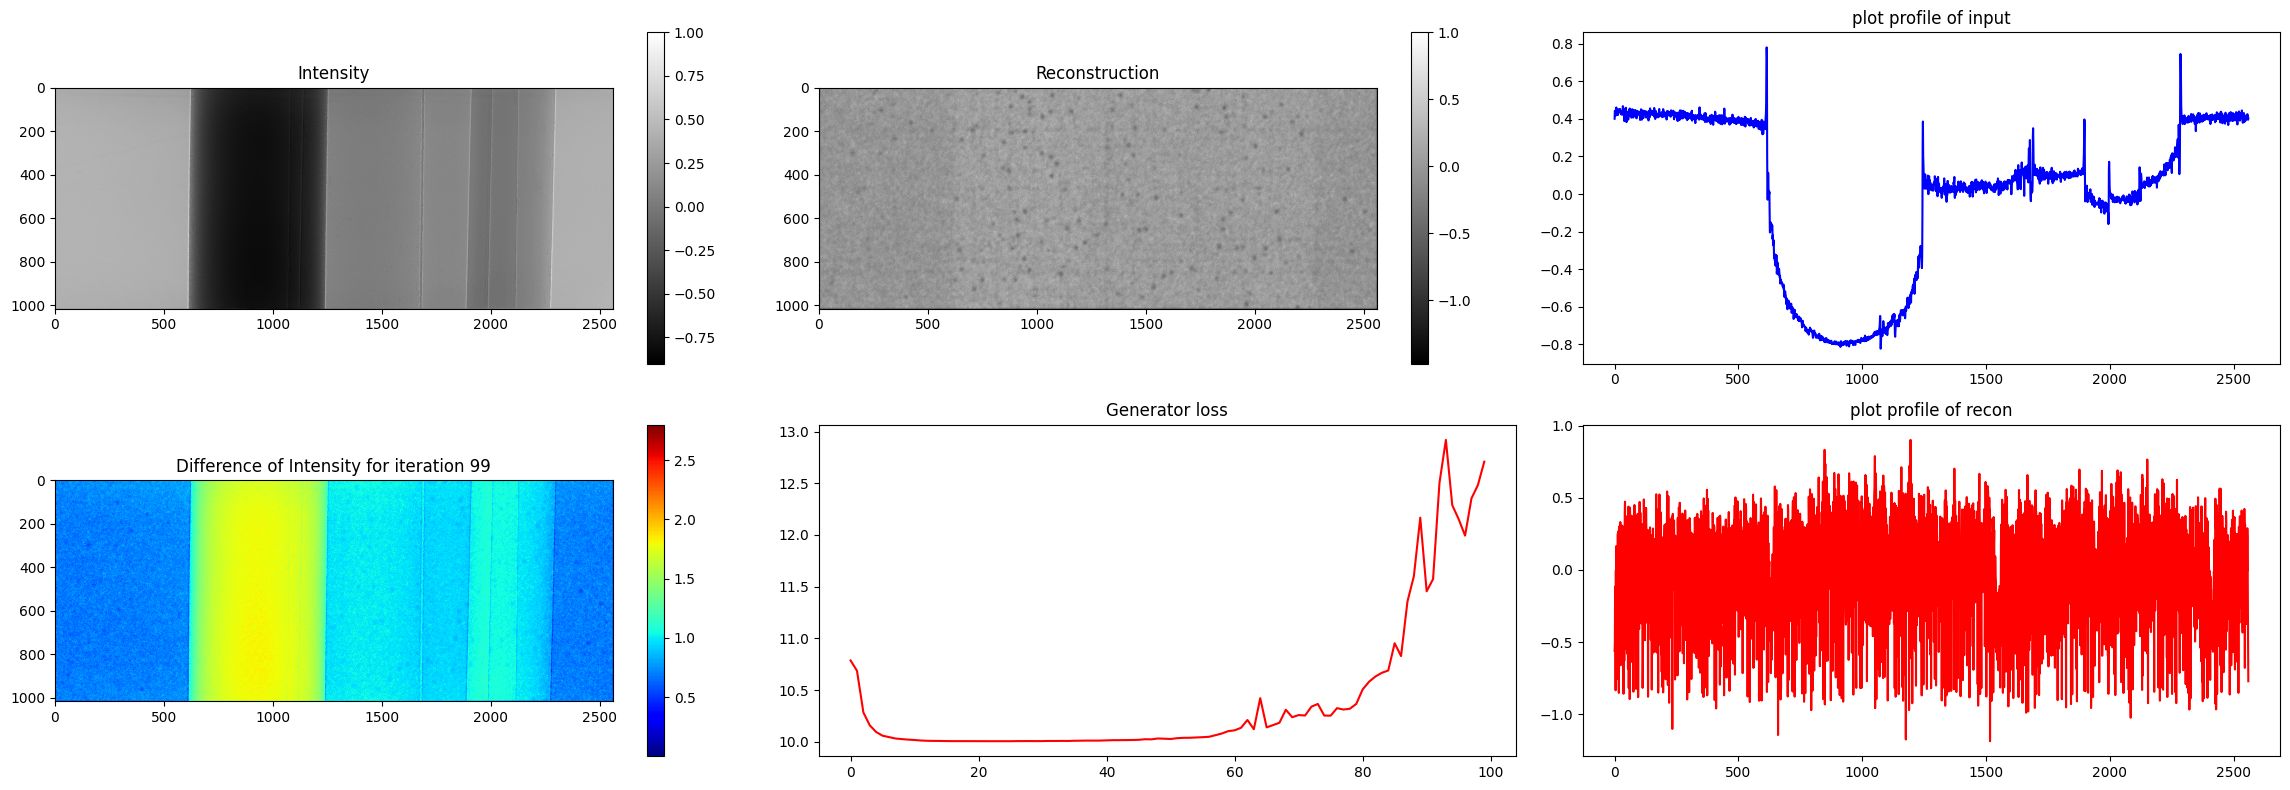

In [199]:
start = time.time()
rec = gan_phase_object.recon
end = time.time()

In [172]:

# print('Running time is {}'.format(end - start))
# io.imsave('data/ganrec/recon/propagation_260_phase.tif', rec[1], check_contrast=False)
# io.imsave('data/ganrec/recon/propagation_260_absorp.tif', rec[0], check_contrast=False)
